# Tutorial 2 (kraci)

In [16]:
import scDML
print(scDML.__version__)
import scanpy as sc 
import torch
from scDML import scDMLModel
from scDML.utils import print_dataset_information
import matplotlib.pyplot as plt
import os
import scib
import anndata as ad
os.system("clear")

###############
dataset="human_pancreas_norm_complexBatch"
ncluster=14
###############

data_dir="/goofys/users/Aleksandra_S/benchmarking_datasets/"+dataset+".h5ad"
adata_raw=ad.read_h5ad(data_dir)
print(adata_raw)
adata_raw.raw=adata_raw
adata_raw.obs['BATCH'] = adata_raw.obs.tech
#adata_raw.obs['celltype'] = adata_raw.obs.assigned_cluster
print_dataset_information(adata_raw,batch_key="BATCH",celltype_key="celltype")

0.0.1


/home/ubuntu/benchmarking_venv/lib/python3.10/site-packages/anndata/_io/specs/registry.py:235: OldFormatWarning: Element '/X' was written without encoding metadata.
  return self.callback(read_func, elem.name, elem, iospec=get_spec(elem))
/home/ubuntu/benchmarking_venv/lib/python3.10/site-packages/anndata/_io/specs/registry.py:235: OldFormatWarning: Element '/layers' was written without encoding metadata.
  return self.callback(read_func, elem.name, elem, iospec=get_spec(elem))
/home/ubuntu/benchmarking_venv/lib/python3.10/site-packages/anndata/_io/specs/registry.py:235: OldFormatWarning: Element '/layers/counts' was written without encoding metadata.
  return self.callback(read_func, elem.name, elem, iospec=get_spec(elem))


AnnData object with n_obs × n_vars = 16382 × 19093
    obs: 'tech', 'celltype', 'size_factors'
    layers: 'counts'
===========print brief infomation of dataset ===============
===========there are 9 batchs in this dataset==============
===========there are 14 celltypes with this dataset=========


/home/ubuntu/benchmarking_venv/lib/python3.10/site-packages/anndata/_io/utils.py:202: OldFormatWarning: Element '/obs/__categories/tech' was written without encoding metadata.
  return func(*args, **kwargs)
/home/ubuntu/benchmarking_venv/lib/python3.10/site-packages/anndata/_io/utils.py:202: OldFormatWarning: Element '/obs/tech' was written without encoding metadata.
  return func(*args, **kwargs)
/home/ubuntu/benchmarking_venv/lib/python3.10/site-packages/anndata/_io/utils.py:202: OldFormatWarning: Element '/obs/__categories/celltype' was written without encoding metadata.
  return func(*args, **kwargs)
/home/ubuntu/benchmarking_venv/lib/python3.10/site-packages/anndata/_io/utils.py:202: OldFormatWarning: Element '/obs/celltype' was written without encoding metadata.
  return func(*args, **kwargs)
/home/ubuntu/benchmarking_venv/lib/python3.10/site-packages/anndata/_io/utils.py:202: OldFormatWarning: Element '/obs/size_factors' was written without encoding metadata.
  return func(*args

celltype,acinar,activated_stellate,alpha,beta,delta,ductal,endothelial,epsilon,gamma,macrophage,mast,quiescent_stellate,schwann,t_cell,Total
BATCH,,,,,,,,,,,,,,,
celseq,228,19,191,161,50,327,5,1,18,1,1,1,1,0,1004
celseq2,274,90,843,445,203,258,21,4,110,15,6,12,4,0,2285
fluidigmc1,21,16,239,258,25,36,14,1,18,1,3,1,5,0,638
inDrop1,110,51,236,872,214,120,130,13,70,14,8,92,5,2,1937
inDrop2,3,81,676,371,125,301,23,2,86,17,9,22,6,2,1724
inDrop3,843,100,1130,787,161,376,92,2,36,14,7,54,1,2,3605
inDrop4,2,52,284,495,101,280,7,1,63,10,1,5,1,1,1303
smarter,0,0,886,472,49,0,0,0,85,0,0,0,0,0,1492
smartseq2,188,55,1008,308,127,444,21,8,213,7,7,6,2,0,2394


## Raw dataset visualization

Note: ovaj dataset je normalizovan!!! <br>
Note that this dataset has the counts already separated in a layer. Here, adata.X contains log transformed scran normalized expression.

In [ ]:
#View raw data,check the batch effect of this batch effect; PODACI SU NORMALIZOVANI pa i ne mora svaki korak da se radi
adata_copy=adata_raw.copy()
sc.pp.normalize_total(adata_copy,target_sum=1e4)
sc.pp.log1p(adata_copy)
sc.pp.highly_variable_genes(adata_copy,n_top_genes=2000,subset=True)
sc.pp.scale(adata_copy)
sc.tl.pca(adata_copy)
sc.pp.neighbors(adata_copy)
sc.tl.umap(adata_copy)
sc.pl.umap(adata_copy,color=["BATCH","celltype"],show=False)

## scDML integration

         Falling back to preprocessing with `sc.pp.pca` and default params.


/home/ubuntu/benchmarking_venv/lib/python3.10/site-packages/anndata/_core/anndata.py:453: PendingDeprecationWarning: The dtype argument will be deprecated in anndata 0.10.0
  warnings.warn(
2023-09-08 15:47:23,575 - root - INFO - mode=unsupervised


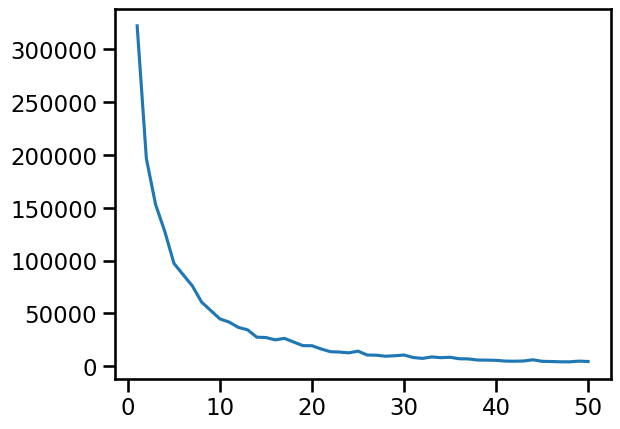

In [ ]:
## fullrun
save_dir="./test_result/"+dataset+"/"

scdml=scDMLModel(verbose=False, save_dir=save_dir)
adata=scdml.preprocess(adata_raw,cluster_method="louvain",resolution=3.0, normalize_features = False, log_normalize = False, normalize_samples=False,n_high_var = 2000)
#print(adata)
scdml.integrate(adata,batch_key="BATCH",ncluster_list=[ncluster],
               expect_num_cluster=ncluster,merge_rule="rule2")

plt.plot(range(1,len(scdml.loss)+1),scdml.loss)

In [ ]:
adata

AnnData object with n_obs × n_vars = 16382 × 1000
    obs: 'tech', 'celltype', 'size_factors', 'BATCH', 'batch', 'init_cluster', 'reassign_cluster'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'hvg', 'pca'
    obsm: 'X_pca', 'X_emb'
    varm: 'PCs'
    layers: 'counts'

2023-09-08 15:49:21,424 - root - INFO - Create log file....
2023-09-08 15:49:21,424 - root - INFO - Create log file....
2023-09-08 15:49:21,427 - root - INFO - Create scDMLModel Object Done....
2023-09-08 15:49:21,427 - root - INFO - Create scDMLModel Object Done....
2023-09-08 15:49:21,432 - root - INFO - Running preprocess() function...
2023-09-08 15:49:21,432 - root - INFO - Running preprocess() function...
2023-09-08 15:49:21,433 - root - INFO - mode=unsupervised
2023-09-08 15:49:21,433 - root - INFO - mode=unsupervised
2023-09-08 15:49:21,435 - root - INFO - clustering method=louvain
2023-09-08 15:49:21,435 - root - INFO - clustering method=louvain
2023-09-08 15:49:21,436 - root - INFO - resolution=1.0
2023-09-08 15:49:21,436 - root - INFO - resolution=1.0
2023-09-08 15:49:21,438 - root - INFO - BATCH_key=BATCH
2023-09-08 15:49:21,438 - root - INFO - BATCH_key=BATCH
2023-09-08 15:49:21,439 - root - INFO - Normalize counts per cell(sum=10000.0)
2023-09-08 15:49:21,439 - root - INFO

         Falling back to preprocessing with `sc.pp.pca` and default params.


/home/ubuntu/benchmarking_venv/lib/python3.10/site-packages/anndata/_core/anndata.py:453: PendingDeprecationWarning: The dtype argument will be deprecated in anndata 0.10.0
  warnings.warn(
2023-09-08 15:49:36,759 - root - INFO - Apply louvain clustring(resolution=1.0) initization
2023-09-08 15:49:36,759 - root - INFO - Apply louvain clustring(resolution=1.0) initization
2023-09-08 15:49:36,762 - root - INFO - Number of Cluster =14
2023-09-08 15:49:36,762 - root - INFO - Number of Cluster =14
2023-09-08 15:49:36,765 - root - INFO - clusters=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]
2023-09-08 15:49:36,765 - root - INFO - clusters=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]
2023-09-08 15:49:36,767 - root - INFO - Preprocess Dataset Done...
2023-09-08 15:49:36,767 - root - INFO - Preprocess Dataset Done...
2023-09-08 15:49:36,769 - root - INFO - mode=unsupervised
2023-09-08 15:49:36,769 - root - INFO - mode=unsupervised
2023-09-08 15:49:36,793 - root - INFO - K_in=5,K_bw=10
2023-

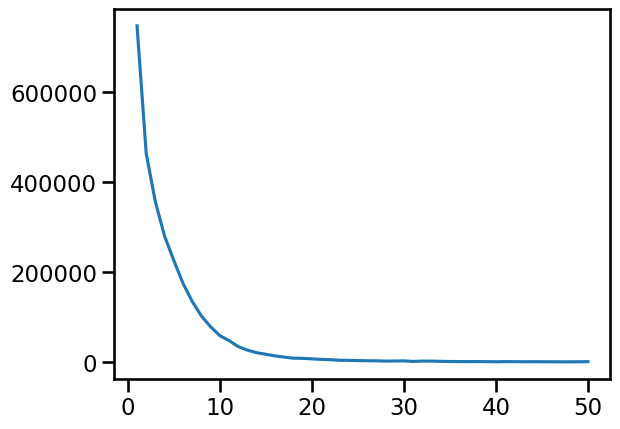

In [ ]:
## fullrun
save_dir="./test_result/"+dataset+"/"

scdml=scDMLModel(save_dir=save_dir)
adata=scdml.preprocess(adata_raw,cluster_method="louvain",resolution=1.0)
#print(adata)
scdml.integrate(adata,batch_key="BATCH",ncluster_list=[ncluster],
               expect_num_cluster=ncluster,merge_rule="rule2")

plt.plot(range(1,len(scdml.loss)+1),scdml.loss)

## visulization of integrated embedding

/home/ubuntu/benchmarking_venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/home/ubuntu/benchmarking_venv/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:163: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = copy(get_cmap(cmap))
/home/ubuntu/benchmarking_venv/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/ubuntu/benchmarking_venv/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/ubuntu/benc

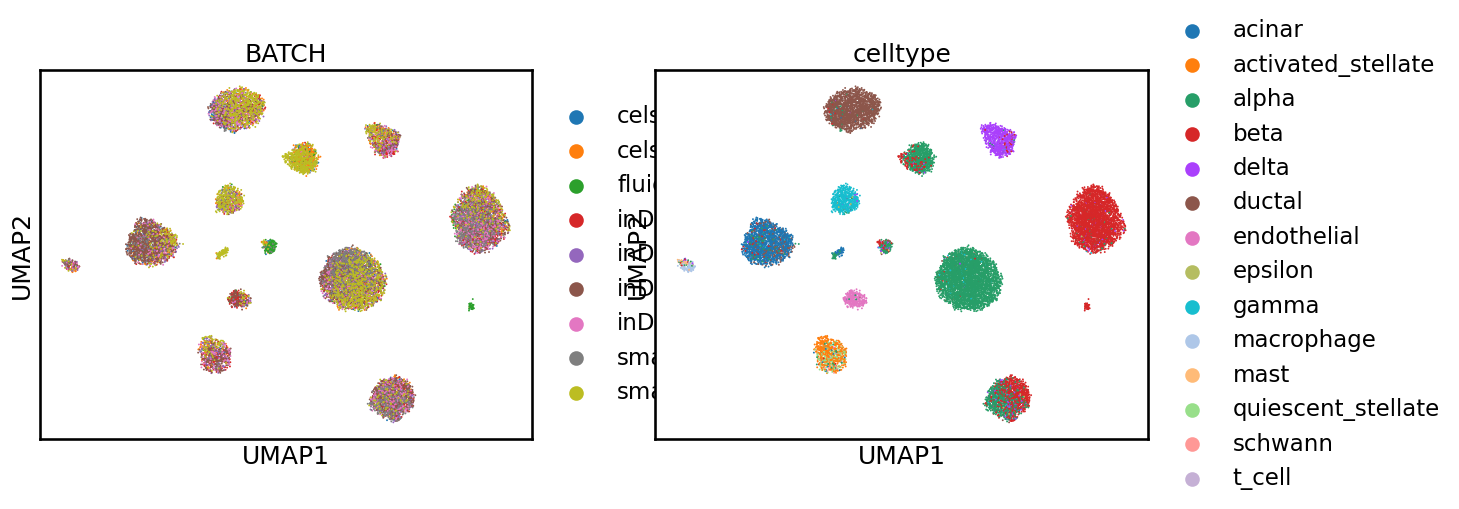

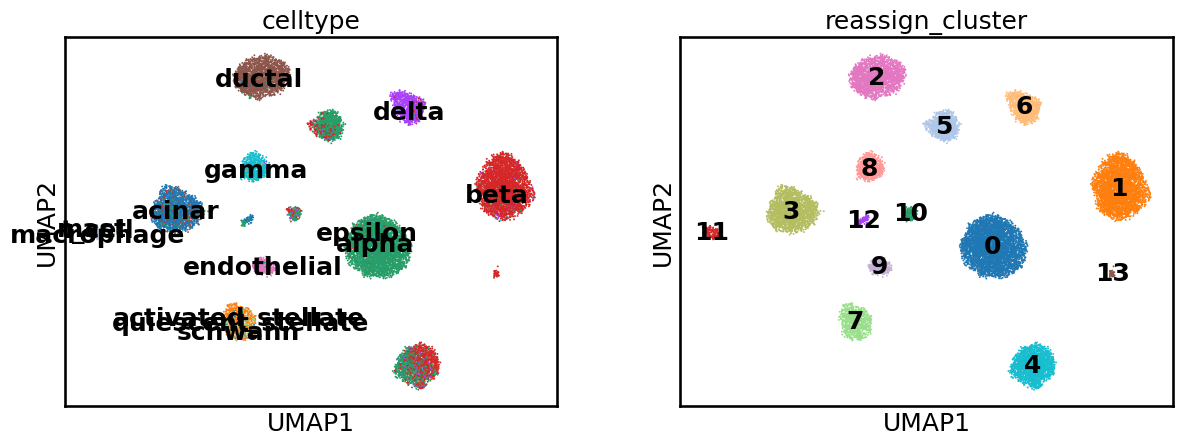

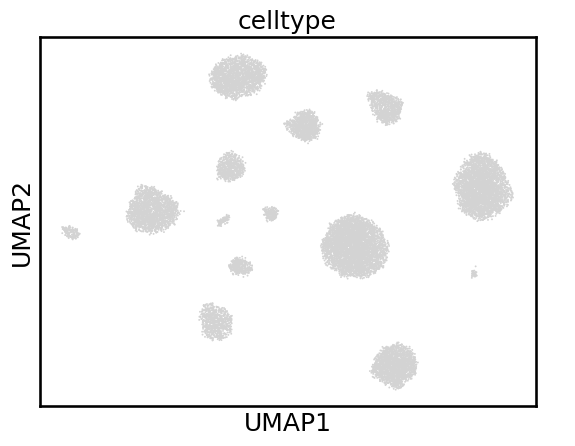

In [ ]:
###########################################
sc.pp.neighbors(adata,random_state=0,use_rep="X_emb")
sc.tl.umap(adata)
###########################################

sc.pl.umap(adata,color=["BATCH", "celltype"],show=False)
#plt.savefig(save_dir+"scDML_embedding1.png")
sc.pl.umap(adata,color=["celltype","reassign_cluster"],legend_loc="on data",show=False)
#plt.savefig(save_dir+"scDML_embedding2.png")

sc.pl.umap(adata,color=["celltype"],groups=["OFFx"],na_in_legend=False)

## evaluation

In [ ]:
import pandas as pd
df=pd.crosstab(adata.obs["celltype"],adata.obs["reassign_cluster"])
col=df.apply('idxmax', axis=1).values
df=df[col]
df

reassign_cluster,3,7,0,1,6,2,9,0,8,11,11,7,7,11
celltype,,,,,,,,,,,,,,
acinar,1557,11,1,0,1,16,1,1,0,2,2,11,11,2
activated_stellate,0,463,0,0,0,0,0,0,0,0,0,463,463,0
alpha,48,19,3812,55,8,20,3,3812,13,10,10,19,19,10
beta,24,3,51,2965,33,9,0,51,3,5,5,3,3,5
delta,2,1,23,86,746,2,0,23,15,4,4,1,1,4
ductal,218,0,4,5,1,1857,1,4,1,1,1,0,0,1
endothelial,0,7,0,1,0,0,305,0,0,0,0,7,7,0
epsilon,0,0,10,1,2,0,0,10,10,0,0,0,0,0
gamma,7,1,55,13,6,2,0,55,550,0,0,1,1,0


In [ ]:
from sklearn.metrics.cluster import adjusted_rand_score,normalized_mutual_info_score
ari=adjusted_rand_score(adata.obs["reassign_cluster"],adata.obs["celltype"])
nmi=normalized_mutual_info_score(adata.obs["reassign_cluster"],adata.obs["celltype"])
print("ARI={}".format(ari))
print("NMI={}".format(nmi))

ARI=0.6156925833581052
NMI=0.6956188822360998


In [ ]:
adata

AnnData object with n_obs × n_vars = 16382 × 1000
    obs: 'tech', 'celltype', 'size_factors', 'BATCH', 'batch', 'init_cluster', 'reassign_cluster'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean-0', 'std-0', 'mean-1', 'std-1', 'mean-2', 'std-2', 'mean-3', 'std-3', 'mean-4', 'std-4', 'mean-5', 'std-5', 'mean-6', 'std-6', 'mean-7', 'std-7', 'mean-8', 'std-8'
    uns: 'pca', 'neighbors', 'umap', 'BATCH_colors', 'celltype_colors', 'reassign_cluster_colors'
    obsm: 'X_pca', 'X_emb', 'X_umap'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'distances', 'connectivities'

In [ ]:
scib.me.ilisi_graph(adata, batch_key="batch", type_="embed", use_rep="X_umap")

Chunk 480 does not have enough neighbors. Skipping...
Chunk 2824 does not have enough neighbors. Skipping...
Chunk 3593 does not have enough neighbors. Skipping...
Chunk 3596 does not have enough neighbors. Skipping...
Chunk 3602 does not have enough neighbors. Skipping...
Chunk 3605 does not have enough neighbors. Skipping...
Chunk 3606 does not have enough neighbors. Skipping...
Chunk 3621 does not have enough neighbors. Skipping...
Chunk 3624 does not have enough neighbors. Skipping...
Chunk 3625 does not have enough neighbors. Skipping...
Chunk 3631 does not have enough neighbors. Skipping...
Chunk 3632 does not have enough neighbors. Skipping...
Chunk 3633 does not have enough neighbors. Skipping...
Chunk 3636 does not have enough neighbors. Skipping...
Chunk 3650 does not have enough neighbors. Skipping...
Chunk 3660 does not have enough neighbors. Skipping...
Chunk 3664 does not have enough neighbors. Skipping...
Chunk 3678 does not have enough neighbors. Skipping...
Chunk 3680 

0.4212637270186482

In [ ]:
scib.me.ilisi_graph(adata, batch_key="batch", type_="embed", use_rep="X_emb")

0.3912002711656878